In [1]:
import sys
sys.path.append('..')
import os
os.chdir('..')
import torch
import torchaudio
import os.path
from arg_extractor import extract_args_from_json
from experiment_builder import VQVAEExperimentBuilder
from model_architectures import VQVAE
from vctk_preprocessor import read_audio
import torchaudio_transforms as transforms
import librosa.display
import matplotlib.pyplot as plt

In [2]:
args = extract_args_from_json('experiment_configs/vqvae_lr1e-6.json')
args.continue_from_epoch = 0
args.eval_speaker_id = 3
args.eval_out_path='audio_out'

args.eval_audio_path = 'data/VCTK-Corpus/wav48/p265/p265_075.wav'

In [3]:
# Load audio
audio_path = os.path.expanduser(args.eval_audio_path)
torchaudio.initialize_sox()
audio, sr = read_audio(audio_path, downsample=True, trim_silence=True)
torchaudio.shutdown_sox()
print(audio.shape)

mulaw = transforms.MuLawEncoding(quantization_channels=args.encoder.num_input_quantization_channels)
mulaw_expanding = transforms.MuLawExpanding(quantization_channels=args.encoder.num_input_quantization_channels)

audio = audio.unsqueeze(0)

torch.Size([1, 36925])


[-0.09838867 -0.03399658  0.10269165 ...  0.02957153  0.0262146
  0.02975464]


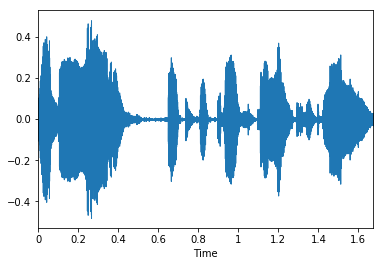

In [4]:
audio_plain = audio.numpy()[0, 0]
print(audio_plain)
plt.figure()
librosa.display.waveplot(audio_plain)

In [5]:
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [6]:
# Prepare model
vqvae_model = VQVAE(
    input_shape=(1, 1, args.input_max_len),
    encoder_arch=args.encoder,
    vq_arch=args.vq,
    generator_arch=args.generator,
    num_speakers=109)

# Load model from state
vqvae_experiment = VQVAEExperimentBuilder(network_model=vqvae_model,
                                    experiment_name=args.experiment_name,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    commit_coefficient=args.commit_coefficient,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=-1,
                                    train_data=None,
                                    val_data=None,
                                    test_data=None,
                                    num_epochs=None)

Building VQVAE.
Building Encoder with 4 downsampling layers.
torch.Size([1, 1, 20000])
torch.Size([1, 16, 6665])
torch.Size([1, 32, 2220])
torch.Size([1, 64, 738])
torch.Size([1, 128, 244])
torch.Size([1, 64, 244])
Building VQ layer.
Building Decoder/Generator with 5 upsampling layers.
torch.Size([1, 64, 244])
torch.Size([1, 128, 730])
torch.Size([1, 128, 2196])
torch.Size([1, 128, 6604])
torch.Size([1, 64, 19903])
torch.Size([1, 32, 20000])
torch.Size([1, 128, 20000])
torch.Size([1, 128, 20000])
torch.Size([1, 256, 20000])
/home/vaidas/Projects/mlpcw/experiments/vqvae_lr1e-6 /home/vaidas/Projects/mlpcw/experiments/vqvae_lr1e-6/result_outputs


In [7]:
out_mulaw = vqvae_experiment.convert(x=mulaw(audio), y=speaker_id)

out = mulaw_expanding(out_mulaw).detach()
print(out_mulaw)
print(out.shape)

tensor([[[-0.0443, -0.0441, -0.0442,  ..., -0.0446, -0.0443, -0.0448],
         [ 0.0840,  0.0839,  0.0838,  ...,  0.0838,  0.0838,  0.0839],
         [-0.0375, -0.0378, -0.0375,  ..., -0.0364, -0.0368, -0.0368],
         ...,
         [-0.0719, -0.0717, -0.0719,  ..., -0.0718, -0.0716, -0.0719],
         [ 0.0501,  0.0497,  0.0500,  ...,  0.0514,  0.0507,  0.0506],
         [ 0.0408,  0.0409,  0.0409,  ...,  0.0398,  0.0405,  0.0405]]],
       grad_fn=<SqueezeBackward1>)
tensor([[139, 139, 139,  ..., 139, 139, 139]])
torch.Size([1, 36929])


In [ ]:
plt.figure()
librosa.display.waveplot(out[0].numpy())

In [ ]:
out.shape

In [ ]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = '{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id)
out_file_path = os.path.join(out_path, out_filename)

# Save as audio
torchaudio.save(filepath=out_file_path, src=out, sample_rate=sr)